In [ ]:
#Self attentions for LLMs (Bahdanau et al., 2014; Vaswani et al., 2017) (nope, that's the transformer paper)
#Focal Loss + batch balancing focal loss (https://arxiv.org/abs/1708.02002) (https://pubmed.ncbi.nlm.nih.gov/37361550/)
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

class MACPredictorLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.3):
        super(MACPredictorLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers,
            batch_first=True,
            dropout=dropout_rate, 
            bidirectional=False
        )
        
        self.dropout = nn.Dropout(dropout_rate)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        
        out = self.fc(out)
        
        return out

def load_data(file_path):
    df = pd.read_json(file_path, lines=True)
    df = df.drop(columns=['d_mac'])
    df = df.fillna(0.0)
    return df

def encode_target(df, le=None, is_train=True):
    # Initialize LabelEncoder for training, or use existing one for testing
    if is_train:
        le = LabelEncoder()
        df['s_mac_encoded'] = le.fit_transform(df['s_mac'])
        num_classes = len(le.classes_)
        return df.drop(columns=['s_mac']), num_classes, le
    else:
        # handle case where mac address seen in test but not in case
        from collections import Counter
        print("Source mac address counts: ")
        print(Counter(df['s_mac'])['14:cc:20:51:33:ea'])
        df['s_mac_encoded'] = le.transform(df['s_mac'])
        return df.drop(columns=['s_mac']), None, le

def scale_features(df, scaler=None, is_train=True):
    # Identify numerical features (all columns except the encoded target)
    feature_cols = [col for col in df.columns if col != 's_mac_encoded']
    
    if is_train:
        scaler = MinMaxScaler()
        df[feature_cols] = scaler.fit_transform(df[feature_cols])
        return df, scaler, feature_cols
    else:
        # Use existing scaler, only transform.
        df[feature_cols] = scaler.transform(df[feature_cols])
        return df, scaler, feature_cols

def create_sequences(df, look_back):
    feature_cols = [col for col in df.columns if col != 's_mac_encoded']
    data = df[feature_cols].values
    target = df['s_mac_encoded'].values
    
    X, Y = [], []
    for i in range(look_back, len(df)):
        X.append(data[i - look_back:i, :])
        Y.append(target[i])

    return np.array(X), np.array(Y)

class MACDataset(Dataset):
    #convert to tensors
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).long() 
        
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [29]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Class weights
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [30]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs):
    """Trains the LSTM model."""
    model.train()
    print(f"\n--- Starting Training on {device} for {num_epochs} epochs ---")
    start_time = time.time()

    train_loss = np.zeros(num_epochs)
    #cosine annealing to stabilize alpha
    
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    for epoch in range(num_epochs):
        total_loss = 0
        for i, (sequences, labels) in enumerate(train_loader):
            sequences = sequences.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            scheduler.step()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
        train_loss[epoch] = avg_loss
        #print(train_loss)

    end_time = time.time()
    print(f"Training Complete. Total time: {(end_time - start_time):.2f}s")
    return train_loss

In [ ]:
def evaluate_model(model, test_loader, device, label_encoder):
    model.eval()
    print("\n--- Starting Evaluation ---")
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            
            outputs = model(sequences)
            
            _, predicted = torch.max(outputs.data, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    
    try:
        sample_true_mac = label_encoder.inverse_transform(y_true)
        sample_pred_mac = label_encoder.inverse_transform(y_pred)
    except ValueError:
        sample_true_mac = [f"Encoded: {i}" for i in y_true]
        sample_pred_mac = [f"Encoded: {i}" for i in y_pred]


    print(f"Classification Accuracy: {accuracy*100:.2f}%")
    print("\nSample Predictions:")
    print(pd.DataFrame({'True MAC': sample_true_mac, 'Predicted MAC': sample_pred_mac}))
    return sample_true_mac, sample_pred_mac

In [ ]:
# --- Data Paths (Update these to your actual file names) ---
TRAIN_FILE = 'all_features_with_mac_part1_80.jsonl'
TEST_FILE = 'all_features_with_mac_part2_20.jsonl'

LOOK_BACK = 10 
BATCH_SIZE = 128
LEARNING_RATE = 0.0005
NUM_EPOCHS = 100
HIDDEN_SIZE = 128
NUM_LAYERS = 4
DROPOUT_RATE = 0.3

# Use GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps')
print(f"Using device: {device}")

df_train = load_data(TRAIN_FILE)
df_test = load_data(TEST_FILE)

df_train, num_classes, le = encode_target(df_train, is_train=True)
df_test, _, _ = encode_target(df_test, le=le, is_train=False)

df_train, scaler, feature_cols = scale_features(df_train, is_train=True)
df_test, _, _ = scale_features(df_test, scaler=scaler, is_train=False)
input_size = len(feature_cols)

X_train, Y_train = create_sequences(df_train, look_back=LOOK_BACK)
X_test, Y_test = create_sequences(df_test, look_back=LOOK_BACK)

if X_train.size == 0 or X_test.size == 0:
    print(f"ERROR: Not enough data points ({len(df_train)} train, {len(df_test)} test) for a look_back of {LOOK_BACK}.")
    print("Please check your input files or reduce the LOOK_BACK value.")

print(f"Sequence created. X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"Input Features: {input_size}, Total Classes: {num_classes}")

train_dataset = MACDataset(X_train, Y_train)
test_dataset = MACDataset(X_test, Y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = MACPredictorLSTM(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE
).to(device)

# criterion = nn.CrossEntropyLoss() 
# Use Focal Loss with class weights
class_weights = compute_class_weight('balanced', 
                                     classes=np.unique(Y_train), 
                                     y=Y_train)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
criterion = FocalLoss(alpha=class_weights_tensor, gamma=2.0)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Using device: mps
Source mac address counts: 
22
Sequence created. X_train shape: (204015, 10, 17), Y_train shape: (204015,)
Input Features: 17, Total Classes: 32


In [33]:
# 7. Train Model
train_loss = train_model(model, train_loader, criterion, optimizer, device, NUM_EPOCHS)


--- Starting Training on mps for 100 epochs ---


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch [1/100], Loss: 3.2006
Epoch [2/100], Loss: 3.2056
Epoch [3/100], Loss: 3.1095
Epoch [4/100], Loss: 3.0812
Epoch [5/100], Loss: 3.0309
Epoch [6/100], Loss: 3.0441
Epoch [7/100], Loss: 3.0458
Epoch [8/100], Loss: 2.9099
Epoch [9/100], Loss: 2.9069
Epoch [10/100], Loss: 2.8418
Epoch [11/100], Loss: 2.7650
Epoch [12/100], Loss: 2.7202
Epoch [13/100], Loss: 2.7499
Epoch [14/100], Loss: 2.7931
Epoch [15/100], Loss: 2.8405
Epoch [16/100], Loss: 2.6733
Epoch [17/100], Loss: 2.6674
Epoch [18/100], Loss: 2.6110
Epoch [19/100], Loss: 2.6393
Epoch [20/100], Loss: 2.6597
Epoch [21/100], Loss: 2.5989
Epoch [22/100], Loss: 2.7790
Epoch [23/100], Loss: 2.5955
Epoch [24/100], Loss: 2.5063
Epoch [25/100], Loss: 2.6119
Epoch [26/100], Loss: 2.4996
Epoch [27/100], Loss: 2.4761
Epoch [28/100], Loss: 2.3957
Epoch [29/100], Loss: 2.3236
Epoch [30/100], Loss: 2.2695
Epoch [31/100], Loss: 2.3054
Epoch [32/100], Loss: 2.3189
Epoch [33/100], Loss: 2.2455
Epoch [34/100], Loss: 2.4064
Epoch [35/100], Loss: 2

In [34]:
print(train_loss)

[3.2005753  3.20563448 3.10950576 3.08120561 3.03085109 3.04407731
 3.04578513 2.90994023 2.9069035  2.84183215 2.76499478 2.72016873
 2.74991809 2.79307573 2.84046214 2.67325789 2.66744862 2.61103397
 2.6393399  2.65965042 2.59889916 2.77895107 2.59554574 2.50632738
 2.61190242 2.49957853 2.47613369 2.39570895 2.32361736 2.2695368
 2.30537078 2.31891572 2.24553312 2.40635951 2.27828346 2.15782422
 2.20027552 2.10247366 2.28653715 2.06657745 2.00059828 2.17202707
 2.08889047 1.98347757 2.03919855 1.94627434 1.97405877 1.86691572
 1.95670288 2.1639673  1.93431001 1.84155091 1.83692187 1.79679396
 1.7881144  1.7470789  1.72817863 1.67654674 1.6705948  1.63286459
 1.74003119 1.63989483 1.59571665 1.58431242 1.58511473 1.62041757
 1.54351458 1.57193134 1.50526945 1.4808622  1.47294285 1.44369691
 1.45467759 1.44120066 1.40738757 1.38780467 1.41942777 1.36023939
 1.34370749 1.52562521 2.06934341 1.53713379 1.42038424 1.34009651
 1.38925301 1.34975235 1.325625   1.34353988 1.30846899 1.33084

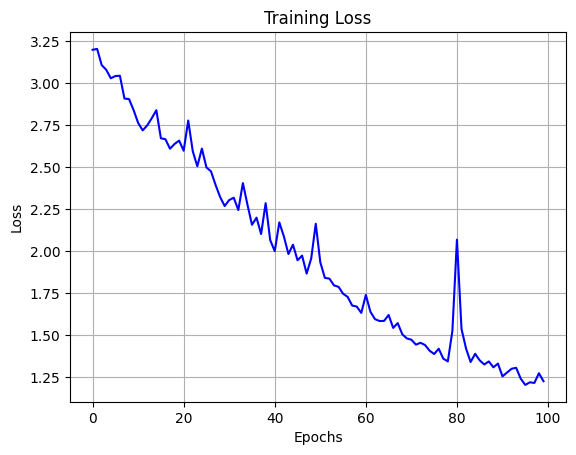

In [43]:
import matplotlib.pyplot as plt
#print(train_loss)
plt.plot(train_loss,color="b")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)

In [44]:
# 8. Evaluate Model
true, pred = evaluate_model(model, test_loader, device, le)


--- Starting Evaluation ---
Classification Accuracy: 23.41%

Sample Predictions:
['74:2f:68:81:69:42' '74:2f:68:81:69:42' '00:16:6c:ab:6b:88' ...
 '74:2f:68:81:69:42' '74:2f:68:81:69:42' '74:2f:68:81:69:42']
@@@@@@@@@@@@@
['74:2f:68:81:69:42' '74:2f:68:81:69:42' '74:2f:68:81:69:42' ...
 '40:f3:08:ff:1e:da' '40:f3:08:ff:1e:da' '40:f3:08:ff:1e:da']
@@@@@@@@@@@@@
                True MAC      Predicted MAC
0      74:2f:68:81:69:42  74:2f:68:81:69:42
1      74:2f:68:81:69:42  74:2f:68:81:69:42
2      00:16:6c:ab:6b:88  74:2f:68:81:69:42
3      08:21:ef:3b:fc:e3  74:2f:68:81:69:42
4      08:21:ef:3b:fc:e3  74:2f:68:81:69:42
...                  ...                ...
50991  74:2f:68:81:69:42  40:f3:08:ff:1e:da
50992  74:2f:68:81:69:42  40:f3:08:ff:1e:da
50993  74:2f:68:81:69:42  40:f3:08:ff:1e:da
50994  74:2f:68:81:69:42  40:f3:08:ff:1e:da
50995  74:2f:68:81:69:42  40:f3:08:ff:1e:da

[50996 rows x 2 columns]


In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [38]:
true
#cf = confusion_matrix(true,pred)
#type(confusion_matrix)

array(['74:2f:68:81:69:42', '74:2f:68:81:69:42', '00:16:6c:ab:6b:88', ...,
       '74:2f:68:81:69:42', '74:2f:68:81:69:42', '74:2f:68:81:69:42'],
      dtype=object)

In [39]:
pred

array(['74:2f:68:81:69:42', '74:2f:68:81:69:42', '74:2f:68:81:69:42', ...,
       '40:f3:08:ff:1e:da', '40:f3:08:ff:1e:da', '40:f3:08:ff:1e:da'],
      dtype=object)

In [40]:
len(np.unique(true))

25

In [41]:
from sklearn.metrics import f1_score

# Macro average (unweighted mean of F1 for each class)
f1_macro = f1_score(true, pred, average='macro')

# Weighted average (weighted by support/frequency of each class)
f1_weighted = f1_score(true, pred, average='weighted')

# Micro average (global calculation)
f1_micro = f1_score(true, pred, average='micro')

print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"F1 Score (micro): {f1_micro:.4f}")

F1 Score (macro): 0.0714
F1 Score (weighted): 0.2220
F1 Score (micro): 0.2341


25   31


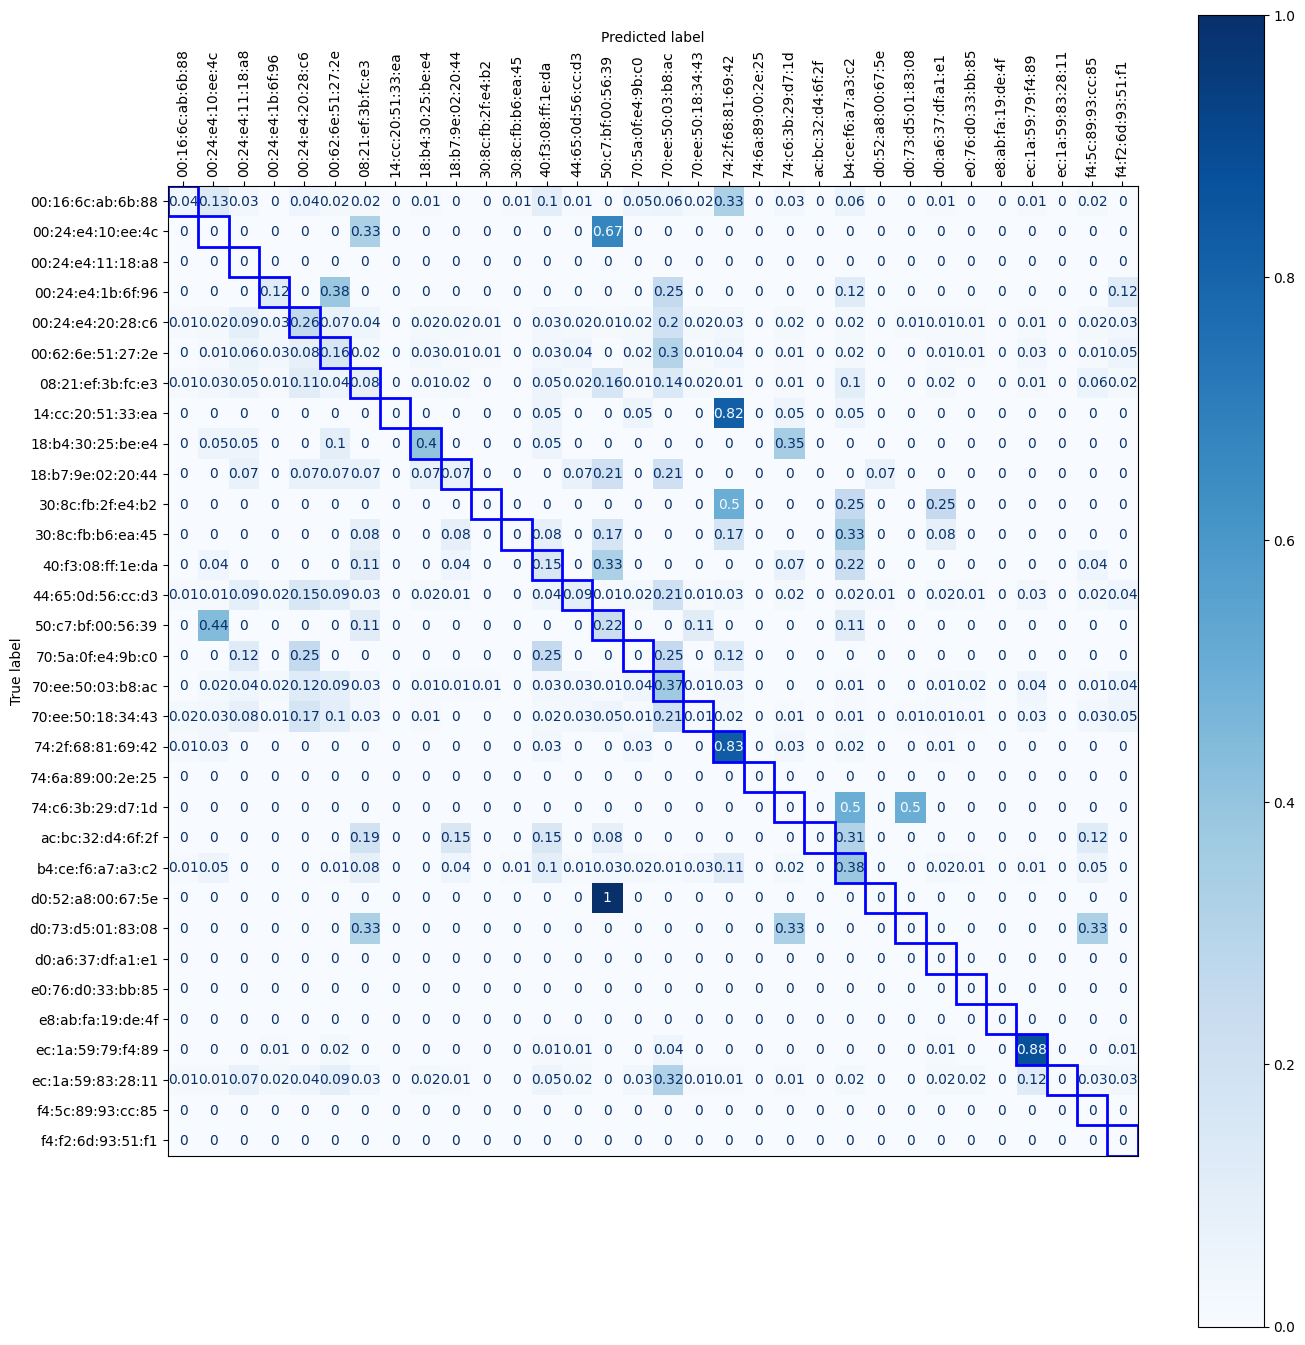

In [42]:
mapping = {}
'''with open("List_Of_Devices.txt",'r') as reader:
    next(reader)
    next(reader)
    for line in reader:
        elements = line.split()
        name, address = " ".join(elements[:-2]), elements[-2]
        #print(name, " ",address)
        mapping[address] = name

print(mapping)'''


labels = sorted(set(true)|set(pred))  # Union of all labels, sorted
print(len(set(true)), " ", len(set(pred)))
cf = confusion_matrix(true,pred,labels=labels,normalize='true')
cf_normalized = np.around(cf,decimals=2)
#cf_normalized= np.around(cf.astype('float') / cf.sum(axis=1)[:, np.newaxis], decimals=2) #normal normalized doesn't round, and .2f doesn't do it that way
#labels = set(pred)
#print(len(labels), " ", len(true))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_normalized,display_labels=labels)

fig, ax = plt.subplots(figsize=(14, 14))
ax.tick_params(
    axis='x',         # Apply to the X-axis
    top=True,         # Show ticks at the top
    labeltop=True,    # Show labels at the top
    bottom=False,     # Hide ticks at the bottom
    labelbottom=False # Hide labels at the bottom
)
ax.xaxis.set_label_position('top')
cm_display.plot(ax=ax, xticks_rotation=90, cmap="Blues")
#box diagonals for better viewing
for i in range(len(labels)):
    ax.add_patch(plt.Rectangle((i-0.5,i-0.5),1,1,fill=False,edgecolor='blue',linewidth=2))
plt.tight_layout()
plt.show()